# 1. Stochastic discrete event model

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint

In [75]:
def simulate_sir_demo(n):
    
    results = []
    
    for i in range(n):
    
    # Set initial numbers
        X = [X_initial]
        Y = [Y_initial]
        Z = [Z_initial]
        t = [0]

        while t[-1] < t_end:
            
            X_now = X[-1]
            Y_now = Y[-1]
            Z_now = Z[-1]
            N_now = X_now + Y_now + Z_now
            
            if Y_now == 0 and Y[-2] > 0:
                print(f'run: {i}, extinction occurs')

            rate_bir = mu * N_now
            rate_tra = beta * X_now * Y_now / N_now
            rate_rec = gamma * Y_now
            rate_xdth = mu * X_now
            rate_ydth = mu * Y_now
            rate_zdth = mu * Z_now

            rates = [rate_bir, rate_tra, rate_rec, rate_xdth, rate_ydth, rate_zdth ]
            
            rate_sum = sum(rates) 

            dt = (-1 / rate_sum) * math.log(np.random.uniform(0,1))

            t.append(t[-1] + dt)

            rand = np.random.uniform(0,1)
            p = rand * rate_sum

            # Birth
            if p < rates[0]:
                X.append(X[-1] + 1)
                Y.append(Y[-1])
                Z.append(Z[-1])
            # Transmission
            elif p > rates[0] and p <= sum(rates[:2]):
                X.append(X[-1] - 1)
                Y.append(Y[-1] + 1)
                Z.append(Z[-1])
            # Recovery
            elif p > sum(rates[:2]) and p <= sum(rates[:3]):
                X.append(X[-1])
                Y.append(Y[-1] - 1)
                Z.append(Z[-1] + 1)
            # Death X, Y, Z
            elif p > sum(rates[:3]) and p <= sum(rates[:4]):
                X.append(X[-1] - 1)
                Y.append(Y[-1])
                Z.append(Z[-1])
            elif p > sum(rates[:4]) and p <= sum(rates[:5]):
                X.append(X[-1])
                Y.append(Y[-1] - 1)
                Z.append(Z[-1])
            elif p > sum(rates[:5]) and p <= rate_sum:
                X.append(X[-1])
                Y.append(Y[-1])
                Z.append(Z[-1] - 1)
        df = pd.DataFrame(
            {
                'X': X,
                'Y': Y,
                'Z': Z,               
            },index = t
        )
        results.append(df)
        
    return results

def sir_demo(xyz, t, beta, gamma, mu):
    '''SIR model with demography.'''
    x, y, z = xyz
    n = x + y + z
    dxdt = mu*n - beta*x*y/n - mu*x
    dydt = beta*x*y/n - gamma*y - mu*y
    dzdt = gamma*y - mu*z
    return dxdt, dydt, dzdt


In [76]:
def nplotfig(n, results):
    fig, ax = plt.subplots()
#     fig.suptitle('Variability')
    for idf in results:
        X = idf['X']
        Y = idf['Y']
        Z = idf['Z']
        t = idf.index
        
        ax.plot(t, X, 'xkcd:blue', label='X')
        ax.plot(t, Y, 'xkcd:red', label='Y')
        ax.plot(t ,Z, 'xkcd:green', label='Z')
    ax.legend(['X', 'Y', 'Z'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Number')
    return fig

def interpolate(n, results):
    df_X = pd.DataFrame()
    df_Y = pd.DataFrame()
    df_Z = pd.DataFrame()
    for i in range(n):
        idf = results[i]
        interval = np.linspace(0,t_end,t_end*50)
        new_index = np.concatenate((idf.index, interval[1:]), axis=None)
        idf1 = idf.reindex(new_index).sort_index()
        idf2 = idf1.interpolate(method = 'index')
        idf3 = idf2.loc[interval,:]
        
        df_X[f'X_{i}'] = idf3['X']
        df_Y[f'Y_{i}'] = idf3['Y']
        df_Z[f'Z_{i}'] = idf3['Z']
        
    return df_X, df_Y, df_Z

def mean(n, results):
    df_X, df_Y, df_Z = interpolate(n, results)
    df_mean = pd.DataFrame({
        'X_mean':df_X.mean(axis = 1),
        'Y_mean':df_Y.mean(axis = 1),
        'Z_mean':df_Z.mean(axis = 1)
    })
    return df_mean
def plot_mean(n, results):
    fig, ax = plt.subplots()
    
    df_mean = mean(n, results)
    ax.plot(df_mean.index, df_mean['X_mean'], 'xkcd:blue', label='X_mean')
    ax.plot(df_mean.index, df_mean['Y_mean'], 'xkcd:red', label='Y_mean')
    ax.plot(df_mean.index ,df_mean['Z_mean'], 'xkcd:green', label='Z_mean')
    
    ax.legend(['X', 'Y', 'Z'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Number')
    
    return

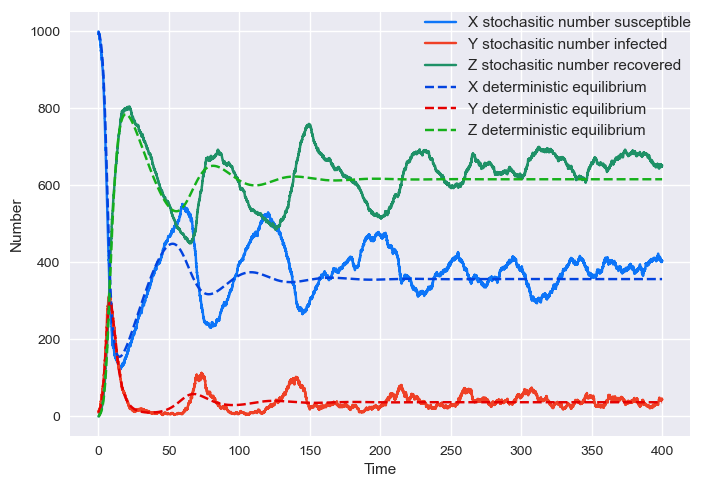

In [77]:
np.random.seed(8)

X_initial = 1000
Y_initial = 10
Z_initial = 0

t_end = 400
mu = 1/50
beta = 1
gamma = 1/3
R0 = beta/(gamma + mu)

df = simulate_sir_demo(1)
X = df[0]['X']
Y = df[0]['Y']
Z = df[0]['Z']
t = df[0].index

fig, ax = plt.subplots()
ax.plot(t, X, 'xkcd:deep sky blue', label='X stochasitic number susceptible')
ax.plot(t, Y, 'xkcd:tomato', label='Y stochasitic number infected')
ax.plot(t ,Z, 'xkcd:viridian', label='Z stochasitic number recovered')

xyz0 = (X_initial, Y_initial, Z_initial)
y = odeint(sir_demo, xyz0, t, args=(beta, gamma, mu))

ax.plot(t, y[:,0], 'xkcd:blue', linestyle='dashed', label='X deterministic equilibrium')
ax.plot(t, y[:,1], 'xkcd:red', linestyle='dashed', label='Y deterministic equilibrium')
ax.plot(t, y[:,2], 'xkcd:green', linestyle='dashed', label='Z deterministic equilibrium')
ax.set_ylabel('Number')
ax.set_xlabel('Time')
ax.legend(bbox_to_anchor = (0.55,0.67), fontsize = 11)
plt.style.use('seaborn-darkgrid')
fig.savefig('part1_transients.png', dpi = 400)

run: 0, extinction occurs


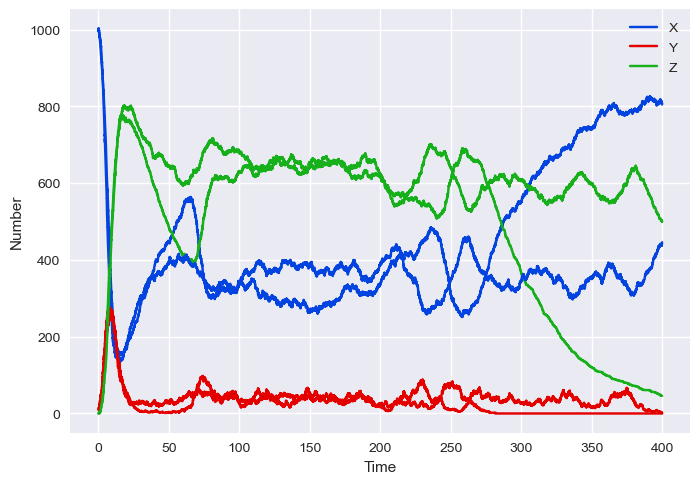

In [78]:
fig = nplotfig(2, simulate_sir_demo(2))
fig.savefig('part1_variability.png', dpi = 400)